Using the theta (inner, central component) axis as the origin of this local coordinate system (posintTP). This preliminary code is to determine the x,y static position of the fiber given a $\theta$ and $\phi$ as measured in the figure: (DESI 899)
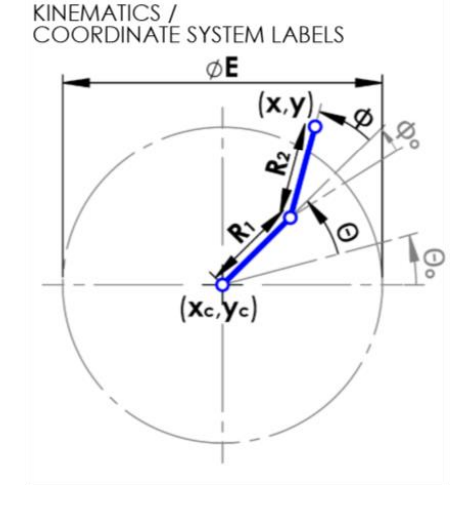

So far, the $\theta$ and $\phi$ initial offsets have both been set to zero (to be changed as I get a better understanding of how the positioners move and are initially set up on the focal plane, if they begin all in the same orientation, or staggered). This seems to imply a simple, rather traditional coordinate transformation between polar and cartesian:

$x = R_\theta \cos\theta + R_\phi \cos\phi$,
$y = R_\theta \sin\theta + R_\phi \sin\phi$ .

This program so far outputs a plot of the fiber at the end of the $\phi$ arm (which I need to check again to see if there's some offset of the ferrule holder off the arm), as well as a shaded area of uncertainty in position due to uncertainty in $R_\theta,R_\phi,\theta,\phi$. On that note, I still need to do a deep dive into the actual data which supplies these uncertainties. So far, this code allows the user to run a debugging mode that takes user input for all values, or display just a single case 
with values for the arms gathered from [DESI-5496](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=5496)(good_positioners_tests_v1,pg.10). Angle error has just been put randomly at 0.25 degrees for each arm for now.

Current questions/confusions/focuses:
1. It seems like the initial angle offsets are not zero, and also have to be calibrated, introducing another variable and uncertainty.
2. Both arc and grid calibrations give error and lengths for the arms, but not yet that I've seen for the angles. The grid-calibration values were chosen because there seemed to be an error with the CAN bus that resulted in poor movement in the arc-calibrations. I need to go into the data for these calibrations still, as well as review how these calibration methods work. 
3. What I have so far isn't too DESI-specific, so my main focus right now is incorporating more specific data and information. I was also thinking about possibly trying to overlay the shape of the poistioner over the stick figure it is now(or at least show the keep out zones/offsets), but I think I want to focus on making it accurate to the data so far.   


In [21]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [22]:
def dtr(angle): #convert degrees(used more commonly in the DESI docs) to radians as needed for math package
    angle_rad = angle*math.pi/180.
    return angle_rad

In [23]:
def position_xy(theta,phi,Rtheta,Rphi):          #angles given in degrees, theta arm = arm 1, phi arm = arm 2
    x1 = Rtheta*math.cos(dtr(theta))
    y1 = Rtheta*math.sin(dtr(theta))
    x2 = x1 + Rphi*math.cos(dtr(phi))
    y2 = y1 + Rphi*math.sin(dtr(phi))
    return x1,y1,x2,y2

In [24]:
def debug_rerun():   #to rerun the program continuously with different parameters
    ask = input("Plot new configuration?(y/n)")
    if (ask == 'y'): 
        theta = float(input("Theta =   (degrees)?"))
        Rtheta = float(input("Length of theta arm =   (mm)?"))
        phi = float(input("Phi =    (degrees)?"))
        Rphi = float(input("Length of phi arm =   (mm)?"))
        delta_theta = float(input("Uncertainty in theta =  (deg)?"))
        delta_phi = float(input("Uncertainty in phi =   (deg)?"))
        delta_Rt = float(input("Uncertainty in length of theta arm =   (mm)?"))
        delta_Rp = float(input("Uncertainty in length of phi arm =    (mm)?"))
        graph_xy(theta,phi,Rtheta,Rphi,delta_theta,delta_phi,delta_Rt,delta_Rp)
        plt.show()
        debug_rerun()
    return

To calculate uncertainty using error propagation:

$x = R_\theta \cos\theta + R_\phi \cos\phi$, where all four variables are assumed to have independent errors.

$\sigma_x = \sqrt{(\cos\theta \delta R_\theta)^2 + (R_\theta~\sin\theta~\delta \theta)^2 + (\cos\phi \delta R_\phi)^2 + (R_\phi~\sin\phi \delta \phi)^2}  .$

Likewise, for $y = R_\theta \sin\theta + R_\phi \sin\phi$:

$\sigma_y = \sqrt{(\sin\theta \delta R_\theta)^2 + (R_\theta \cos\theta~\delta \theta)^2 + (\sin\phi \delta R_\phi)^2 + (R_\phi \cos\phi \delta \phi)^2}  .$


In [25]:
def uncertainty(theta,phi,Rtheta,Rphi,delta_theta,delta_phi,delta_Rt,delta_Rp):
    theta = dtr(theta) #converting from degrees to radians before using the math package
    phi = dtr(phi)
    delta_theta = dtr(delta_theta)
    delta_phi = dtr(delta_phi)
    
    sigmax = math.sqrt(((math.cos(theta))*delta_Rt)**2. + (Rtheta*math.sin(theta)*delta_theta)**2 + (math.cos(phi)*delta_Rp)**2 + (Rphi*math.sin(phi)*delta_phi)**2)
    sigmay = math.sqrt((math.sin(theta)*delta_Rt)**2 + (Rtheta*math.cos(theta)*delta_theta)**2 + (math.sin(phi)*delta_Rp)**2 + (Rphi*math.cos(phi)*delta_phi)**2)
    
    return sigmax,sigmay

In [26]:
#cell to debug uncertainties by comparing with hand calculations
#uncertainty(30,60,2.93,2.99,0.25,0.25,0.22,0.24)

In [27]:
def graph_xy(theta,phi,Rtheta,Rphi,delta_theta,delta_phi,delta_Rt,delta_Rp):
    xc,yc = 0.,0. #for now, most likely needs to be changed
    
    x1,y1,x2,y2 = position_xy(theta,phi,Rtheta,Rphi)
    xs = [xc,x1,x2]
    ys = [yc,y1,y2]
    
    fiberx = x2
    fibery = y2   #marking the fiber on the graph, still need to check the specifications for any offset from arm
    
    #Making a shaded region of uncertainty in position of the fiber
    sigmax,sigmay = uncertainty(theta,phi,Rtheta,Rphi,delta_theta,delta_phi,delta_Rt,delta_Rp)
    uncertainty_area = patches.Ellipse((x2,y2),sigmax,sigmay,color='grey',label='Uncertainty')
    
    xaxis1 = [-3.,7]      #making a fixed x-axis, commented out to zoom in on the fiber
    xaxis2 = [0.,0.]
    yaxis1 = [0.,0.]      #making a fixed y-axis
    yaxis2 = [-3.,7.]
    
    fig, ax = plt.subplots()
    #ax.scatter(xs,ys)
    
    plt.plot(xs,ys,'-',label='Pos. Arms')
    #plt.plot(xaxis1,xaxis2,'-',color='black')
    #plt.plot(yaxis1,yaxis2,'-',color='black')
    plt.plot(fiberx,fibery,'.',color='red',markersize=0.3033,label = 'Fiber') #calc'd in pts, with diam = 107um
    ax.add_patch(uncertainty_area)
    plt.legend(loc='lower left')
    plt.axis()
    plt.grid(which='major',axis='both')
    plt.title("Positioner Arms centered on Itself")
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    
    plt.show()
    
    print(f"For angular position ({theta},{phi}), estimated Cartesian position is ({round(x2,3)} +/- {round(sigmax,3)}, {round(y2,3)} +/- {round(sigmay,3)})")

In [28]:
def main():
    #For positioner at (xc,yc) = (0,0) by default
    xc,yc = 0.,0.
    ask = input("Run debugging? (y/n)")
    if (ask == 'y'): 
        debug_rerun()
    else: graph_xy(30,60,2.93,2.99,0.25,0.25,0.22,0.24)
    return

Run debugging? (y/n)n


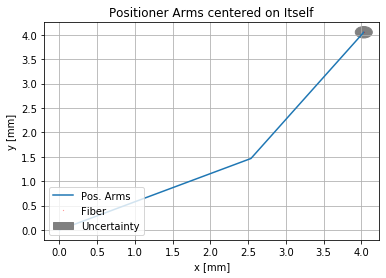

For angular position (30,60), estimated Cartesian position is (4.032 +/- 0.226, 4.054 +/- 0.236)


In [29]:
main()
